Predicting NVIDIA stock adj-close using LSTM model

reference：https://blog.csdn.net/mighty13/article/details/113819660

part 1: data preprocessing

1.1 import library and dataset

In [1]:
import pandas as pd
import numpy as np

import statsmodels.tsa.stattools as stat

from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdate

import time
from datetime import date

from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

data = pd.read_csv('./NVDA 18-24.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-19,62.044998,62.337502,59.250000,60.250000,59.649902,71377200
1,2018-03-20,60.279999,62.787498,60.279999,62.395000,61.773552,55469600
2,2018-03-21,62.330002,63.000000,61.832500,62.139999,61.521091,43868800
3,2018-03-22,61.500000,61.970001,60.084999,60.462502,59.860310,55119600
4,2018-03-23,60.599998,60.625000,58.130001,58.242500,57.662403,73562000
...,...,...,...,...,...,...,...
1504,2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400
1505,2024-03-12,880.489990,919.599976,861.500000,919.130005,919.130005,66807500
1506,2024-03-13,910.549988,915.039978,884.349976,908.880005,908.880005,63571300
1507,2024-03-14,895.770020,906.460022,866.000000,879.440002,879.440002,60231800


1.2 set train-test ratio

In [2]:
test_size = 0.05               
val_size = 0.25  
train_size = 0.7      

n = len(data)
n_70 = int(train_size * n)
n_25 = int(val_size * n)
test_len = int(test_size * n)+1

test_time=data['Date'].iloc[n_70+n_25:]
SEQLEN=6

In [3]:
full_time=data['Date']
train_time=data['Date'].iloc[:n_70]
val_time=data['Date'].iloc[n_70:n_70+n_25]
test_time=data['Date'].iloc[n_70+n_25:]

In [4]:
data.set_index(["Date"], inplace=True)

1.3 normalize dataste

In [5]:
data_70 = data.iloc[:n_70]
data_25 = data.iloc[n_70:n_70+n_25]
data_05 = data.iloc[n_70+n_25:]

scaler70 = StandardScaler()
scaler70.fit(data_70)
train = scaler70.transform(data_70)

scaler25 = StandardScaler()
scaler25.fit(data_25)
val = scaler25.transform(data_25)

scaler05 = StandardScaler()
scaler05.fit(data_05)
test = scaler05.transform(data_05)

data_scaled = pd.DataFrame(np.concatenate([train,val,test]), columns=data.columns)

1.4 lag features

In [6]:
t0=data_scaled.values

dim_in =  data_scaled.shape[1]
dim_out = data_scaled.shape[1]

X_train = np.zeros((t0.shape[0]-SEQLEN-test_len, SEQLEN, dim_in))
Y_train = np.zeros((t0.shape[0]-SEQLEN-test_len, dim_out))
X_test = np.zeros((test_len, SEQLEN, dim_in))
Y_test = np.zeros((test_len, dim_out),)

for i in range(SEQLEN, t0.shape[0]-test_len):
    Y_train[i-SEQLEN] = t0[i]
    X_train[i-SEQLEN] = t0[(i-SEQLEN):i]
for i in range(t0.shape[0]-test_len,t0.shape[0]):
    Y_test[i-t0.shape[0]+test_len] = t0[i]
    X_test[i-t0.shape[0]+test_len] = t0[(i-SEQLEN):i]


part 2: LSTM Model

2.1 build LSTM model and train model

In [7]:
X_train_partial = X_train[:n_70]
Y_train_partial = Y_train[:n_70]
X_val = X_train[n_70:]
Y_val = Y_train[n_70:]

model = Sequential()
model.add(LSTM(32, input_shape=(SEQLEN, dim_in),activation='relu',recurrent_dropout=0.01))
model.add(Dense(32, kernel_initializer='glorot_uniform', activation='linear')) 
model.add(Dense(dim_out, activation='linear'))  
model.compile(optimizer='rmsprop', loss='mean_squared_error')

history = model.fit(X_train_partial, Y_train_partial, epochs=200, batch_size=32, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/200
33/33 [==============================] - 2s 15ms/step - loss: 0.4300 - val_loss: 0.1756
Epoch 2/200
33/33 [==============================] - 0s 10ms/step - loss: 0.1392 - val_loss: 0.1492
Epoch 3/200
33/33 [==============================] - 0s 10ms/step - loss: 0.1145 - val_loss: 0.1499
Epoch 4/200
33/33 [==============================] - 0s 10ms/step - loss: 0.1080 - val_loss: 0.1445
Epoch 5/200
33/33 [==============================] - 0s 11ms/step - loss: 0.1050 - val_loss: 0.1442
Epoch 6/200
33/33 [==============================] - 0s 10ms/step - loss: 0.1022 - val_loss: 0.1439
Epoch 7/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0980 - val_loss: 0.1400
Epoch 8/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0975 - val_loss: 0.1453
Epoch 9/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0967 - val_loss: 0.1394
Epoch 10/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0945 - val_loss: 0.1373

2.2 prediction

In [8]:
preddf=model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


2.3 restore data

In [9]:
name=data.columns.tolist()

test_time = pd.to_datetime(test_time)

Y_test=pd.DataFrame(data_05['Adj Close'])
Y_test.set_index(test_time, inplace=True)

preddf= scaler05.inverse_transform(preddf)
preddf=pd.DataFrame(preddf)
preddf.set_index(test_time, inplace=True)

2.4 visual prediction result

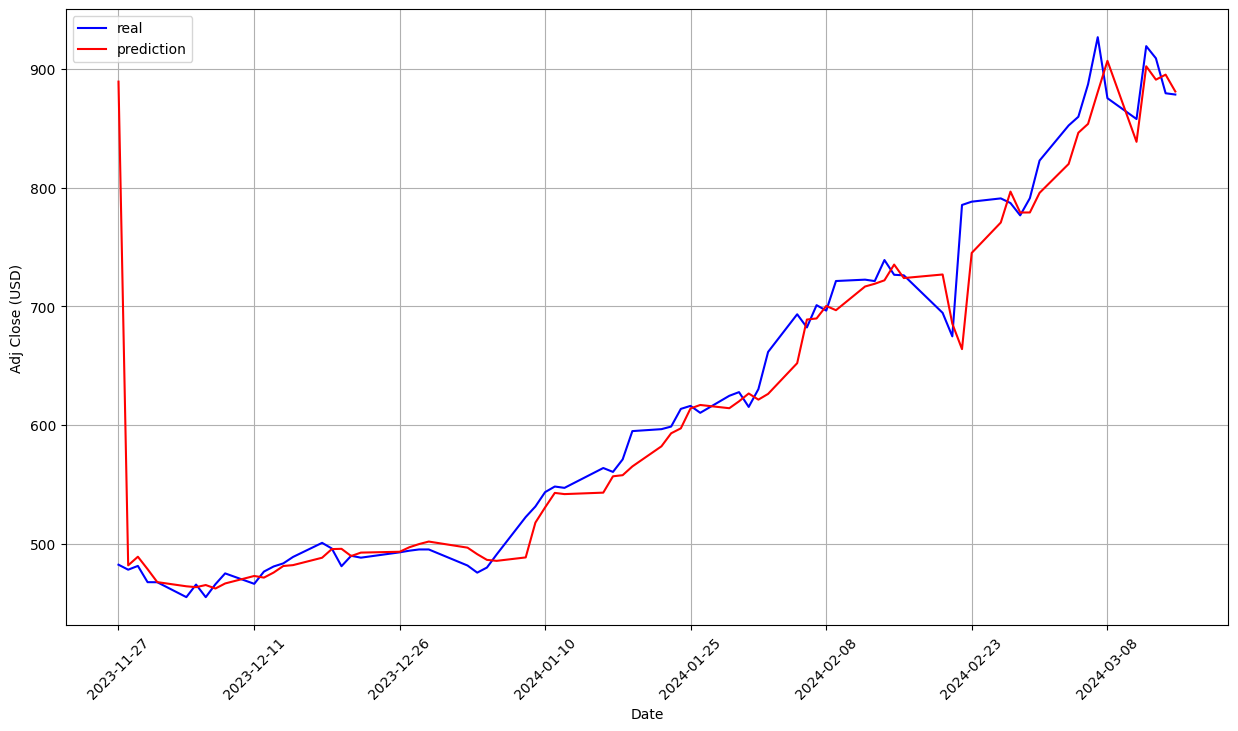

In [10]:
dates = pd.to_datetime(test_time)
n = 10
dates_to_show = dates[::n]

plt.figure(figsize=(15,8))
plt.plot(dates, Y_test['Adj Close'], c='blue', label='real')
plt.plot(dates, preddf.iloc[:,4], c='red', label='prediction')
plt.xticks(dates_to_show,rotation=45)
plt.ylabel('Adj Close (USD)')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

2.5 evaluation

In [11]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
rmse=math.sqrt(mean_squared_error(Y_test['Adj Close'],preddf.iloc[:,4]) )

mape=mape(Y_test['Adj Close'],preddf.iloc[:, 4])
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % mape)


RMSE on test set = 51.451
MAPE on test set = 3.204%
